<a href="https://colab.research.google.com/github/Sidhtang/CNN-classification-using-mnist-dataset/blob/main/mnist_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.4MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 491kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.58MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.75MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epoch 1: Train Loss = 0.3084, Val Loss = 0.0731
Epoch 2: Train Loss = 0.1417, Val Loss = 0.0631
Epoch 3: Train Loss = 0.1178, Val Loss = 0.0505
Epoch 4: Train Loss = 0.0996, Val Loss = 0.0517
Epoch 5: Train Loss = 0.0899, Val Loss = 0.0436
Epoch 6: Train Loss = 0.0827, Val Loss = 0.0406
Epoch 7: Train Loss = 0.0760, Val Loss = 0.0397
Epoch 8: Train Loss = 0.0691, Val Loss = 0.0385
Epoch 9: Train Loss = 0.0671, Val Loss = 0.0355
Epoch 10: Train Loss = 0.0601, Val Loss = 0.0357


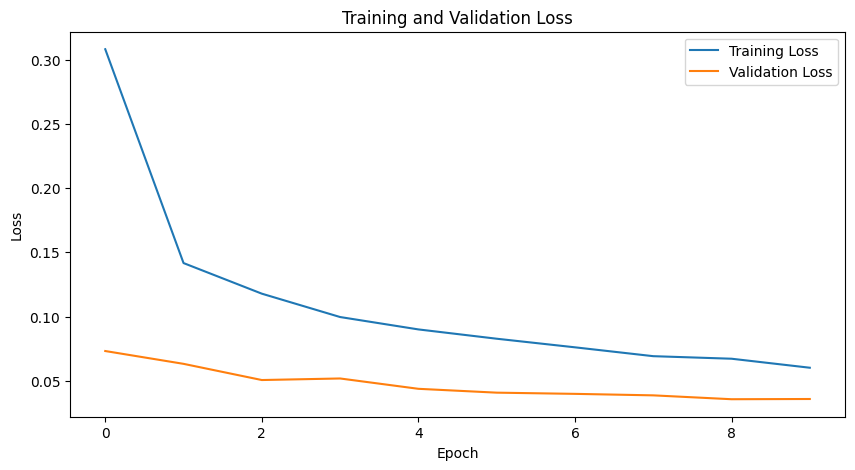

Test Accuracy: 99.19%


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)

# Data Preprocessing and Loading
def prepare_mnist_data():
    """Prepare MNIST dataset with appropriate transformations"""
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    # Download and load training data
    train_dataset = torchvision.datasets.MNIST(
        root='./data',
        train=True,
        download=True,
        transform=transform
    )

    # Download and load test data
    test_dataset = torchvision.datasets.MNIST(
        root='./data',
        train=False,
        download=True,
        transform=transform
    )

    # Split training data into train and validation sets
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(
        train_dataset, [train_size, val_size]
    )

    # Create DataLoaders
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=64, shuffle=True
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=64, shuffle=False
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=64, shuffle=False
    )

    return train_loader, val_loader, test_loader

# Neural Network Architecture
class MNISTClassifier(nn.Module):
    def __init__(self):
        super(MNISTClassifier, self).__init__()

        # Convolutional Layers
        self.conv_layers = nn.Sequential(
            # First Convolutional Layer with Batch Normalization
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),

            # Second Convolutional Layer with Batch Normalization
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )

        # Fully Connected Layers
        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10)  # 10 output classes for digits 0-9
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc_layers(x)
        return x

# Training Function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0.0

        # Training Phase
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()

        # Validation Phase
        model.eval()
        epoch_val_loss = 0.0
        with torch.no_grad():
            for data, target in val_loader:
                output = model(data)
                loss = criterion(output, target)
                epoch_val_loss += loss.item()

        # Average losses
        train_loss = epoch_train_loss / len(train_loader)
        val_loss = epoch_val_loss / len(val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f'Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}')

    return train_losses, val_losses

# Evaluation Function
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    return accuracy

# Plotting Function
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Main Execution
def main():
    # Prepare data
    train_loader, val_loader, test_loader = prepare_mnist_data()

    # Initialize model, loss, and optimizer
    model = MNISTClassifier()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    train_losses, val_losses = train_model(
        model, train_loader, val_loader, criterion, optimizer
    )

    # Plot losses
    plot_losses(train_losses, val_losses)

    # Evaluate on test set
    evaluate_model(model, test_loader)

if __name__ == '__main__':
    main()